In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from OnlineBCA import *
np.random.seed(1000) # Seed for reproducibility
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

# Source Generation and Mixing

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.8, df = 4, n_sources = NumberofSources, size_sources = N , decreasing_correlation = True)
S = 2 * S -1 
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 31.084901161085142


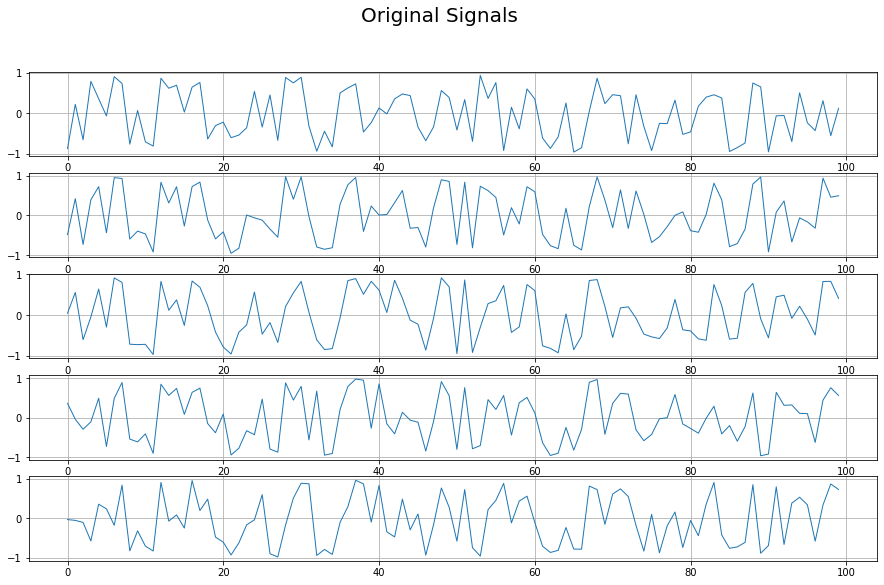

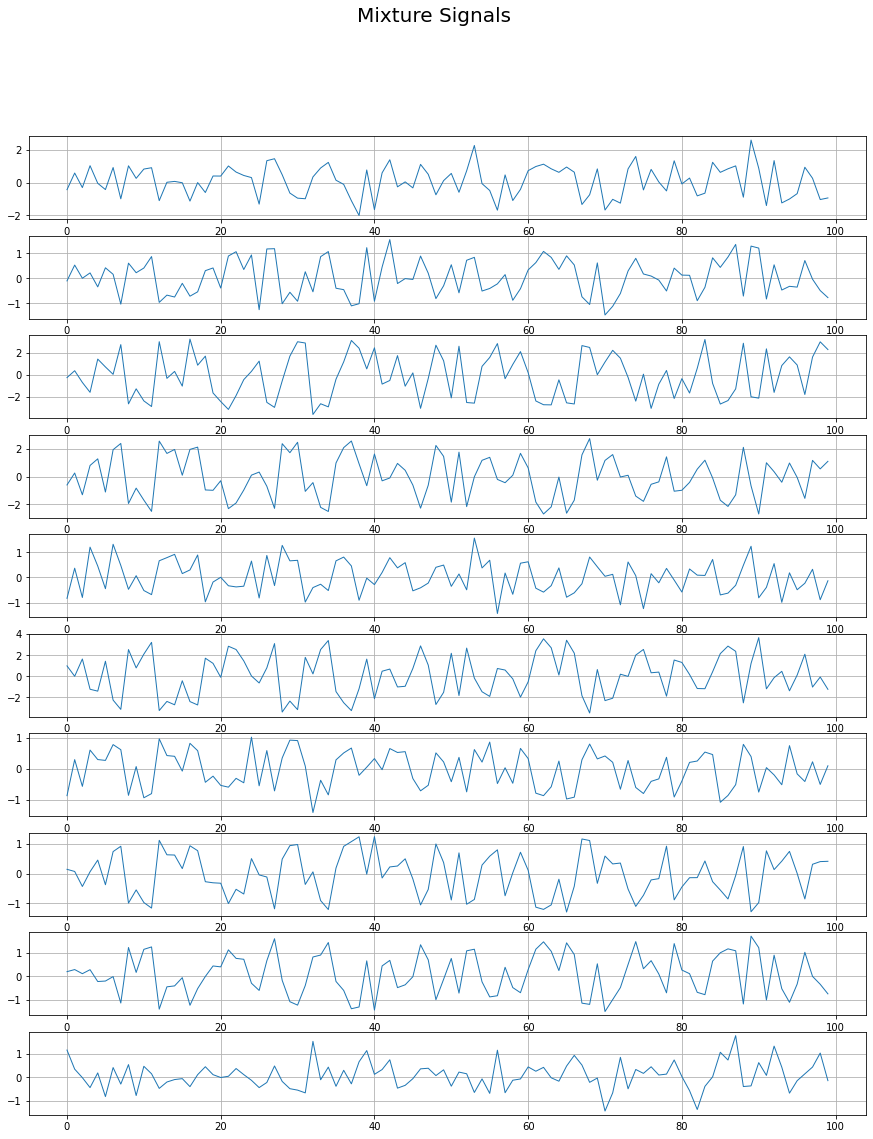

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Fit Model

In [5]:
# HYPERPARAMETERS DEFINED IN THE PAPER
lambda_ = 0.999
mu_F = 1e-3
beta = 30
debug_iteration_point = 1000

model = OnlineBCA(s_dim = NumberofSources, x_dim = NumberofMixtures, 
                  lambda_ = lambda_, mu_F = mu_F, beta = beta, set_ground_truth = True, S = S, A = A)

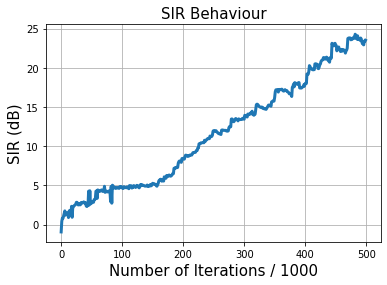

100%|█████████████████████████████████| 500000/500000 [01:57<00:00, 4260.88it/s]


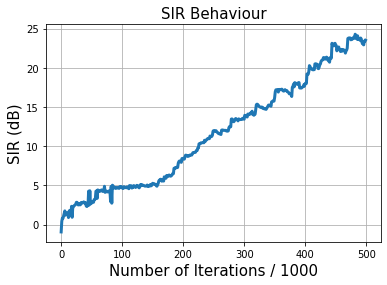

In [6]:
model.fit_batch_antisparse(X, n_epochs = 1, neural_dynamic_iterations = 500, 
                           shuffle = True, debug_iteration_point = debug_iteration_point,plot_in_jupyter = True)

# Final SINR (Signal to Interference and Noise Ratio) and Convergence Behavior

Final SIR: 23.521892925188045


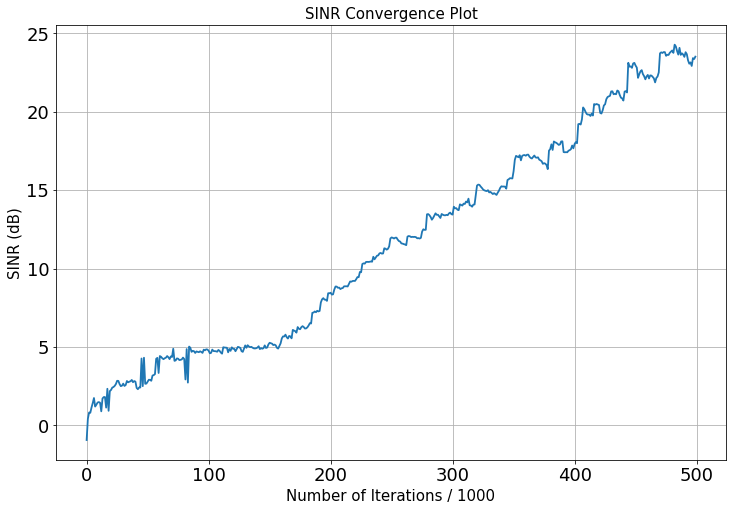

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SIR: {}'.format(np.array(model.SIR_list[-1])))

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y.shape, X.shape, S.shape

((5, 500000), (10, 500000), (5, 500000))

In [9]:
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T

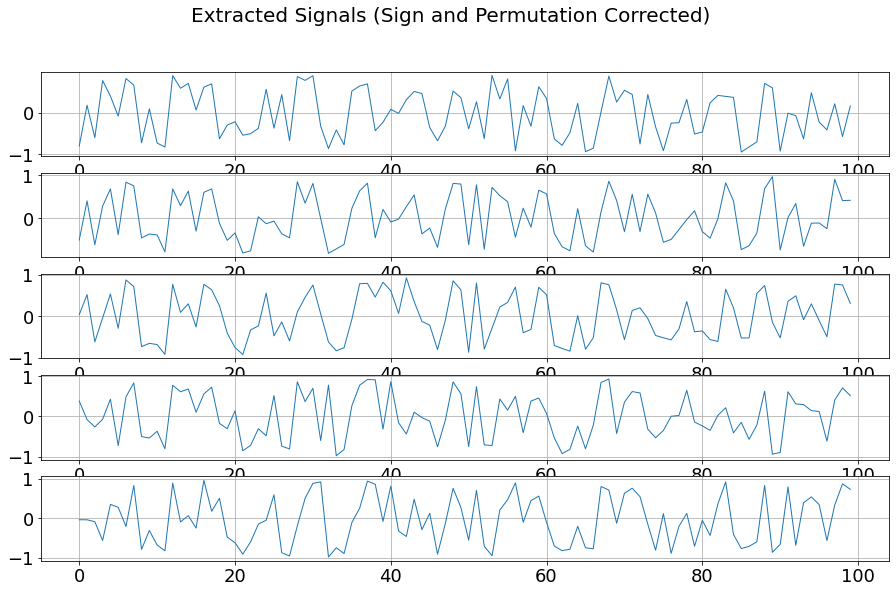

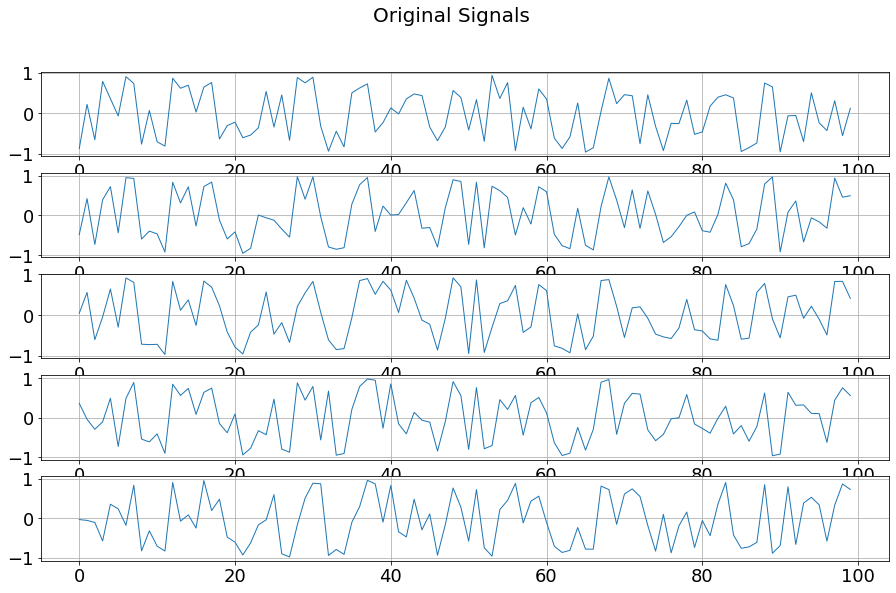

In [10]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)